In [1]:
import pandas as pd
from util import read_data

relacoes_entre_cnpjs = read_data.salvar_relacoes_entre_cnpjs()
informacoes_licitacoes = read_data.salvar_informacoes_licitacoes()
cnpjs_por_licitacao = read_data.salvar_cnpjs_por_licitacao()


### Vamos analisar as licitações em nível municipal

#### Começamos selecionando uma cidade:

In [2]:
cidades = informacoes_licitacoes['nom_entidade'].unique()
cidades[:5]

array(['Cascalho Rico', 'Muriaé', 'Coronel Fabriciano',
       'Catas Altas da Noruega', 'Nova Era'], dtype=object)

#### Escolhemos o município de Cascalho Rico.

1. Selecionamos as licitações correspondentes ao município.

In [3]:
licitacoes_do_municipio = informacoes_licitacoes.loc[informacoes_licitacoes['nom_entidade'] == cidades[0]]
licitacoes_do_municipio = licitacoes_do_municipio['seq_dim_licitacao']
licitacoes_do_municipio

0         746396
1         746397
2         746398
3         746399
4         746400
           ...  
175650    746391
175651    746392
175653    746393
175654    746394
175655    746395
Name: seq_dim_licitacao, Length: 182, dtype: object

2. Filtramos o arquivo de cnpjs licitantes pelas licitações do município.

In [4]:
cnpjs_licitantes = cnpjs_por_licitacao[cnpjs_por_licitacao['seq_dim_licitacao'].isin(licitacoes_do_municipio)]
cnpjs_licitantes

# observacao: verificar se ha informacoes dos cnpjs para todas as licitacoes do municipio

,seq_dim_licitacao,num_documento
92938,746408,18295299000114
92939,746413,10620186000135
92946,746423,05788495000189
92947,746426,05382778000126
92948,746434,07840525000184
...,...,...
423321,746473,56081482000106
423372,746496,18397159000157
423373,746496,21471613000187
423374,746514,14493848000104


#### 3. Verificacao de relacoes entre CNPJs do municipio (ainda sem entrar no nivel de licitacoes)

In [5]:
import networkx as nx

G = nx.Graph()

# deve existir uma forma mais inteligente de fazer isso usando funcoes nativas
for cnpj in cnpjs_licitantes['num_documento']:
    G.add_node(cnpj)
    relacoes_do_cnpj = relacoes_entre_cnpjs.loc[relacoes_entre_cnpjs[0] == cnpj]
    
    for relacao in relacoes_do_cnpj.values:
        if relacao[1] in cnpjs_licitantes.values:
            G.add_edge(relacao[0], relacao[1])

#### 4. Impressão do grafo do município

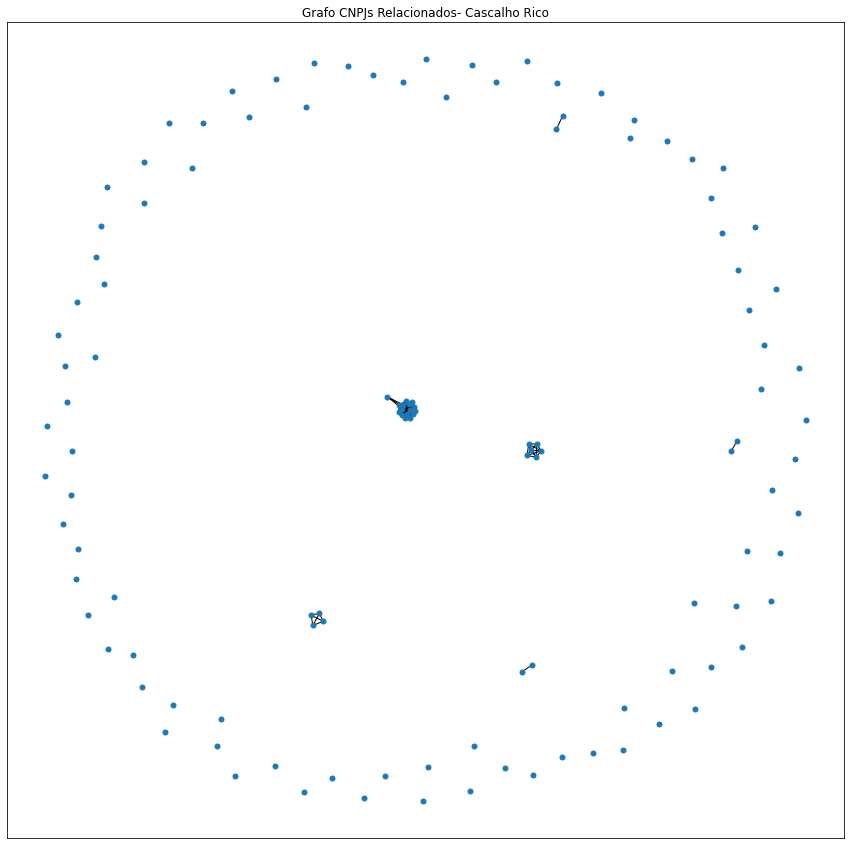

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.title('Grafo CNPJs Relacionados- Cascalho Rico')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=25)
nx.draw_networkx_edges(G, pos)

plt.show()

## Compilando em uma funcao:

In [7]:
def plota_grafo_municipio(municipio: str) -> plt.figure:
    """Plota o grafo do municipio escolhido.
    Deve estar dentro do contexto dos DataFrames,
    possivel implementacao em classe."""

    licitacoes_do_municipio = informacoes_licitacoes.loc[informacoes_licitacoes['nom_entidade'] == municipio]
    licitacoes_do_municipio = licitacoes_do_municipio['seq_dim_licitacao']
    
    cnpjs_licitantes = cnpjs_por_licitacao[cnpjs_por_licitacao['seq_dim_licitacao'].isin(licitacoes_do_municipio)]

    G = nx.Graph()

    for cnpj in cnpjs_licitantes['num_documento']:
        G.add_node(cnpj)
        relacoes_do_cnpj = relacoes_entre_cnpjs.loc[relacoes_entre_cnpjs[0] == cnpj]
        for relacao in relacoes_do_cnpj.values:
            if relacao[1] in cnpjs_licitantes.values:
                G.add_edge(relacao[0], relacao[1])

    plt.figure(figsize=(15, 15))    
    plt.title('Grafo CNPJs Relacionados- {}'.format(municipio))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=25)
    nx.draw_networkx_edges(G, pos)
    plt.show()

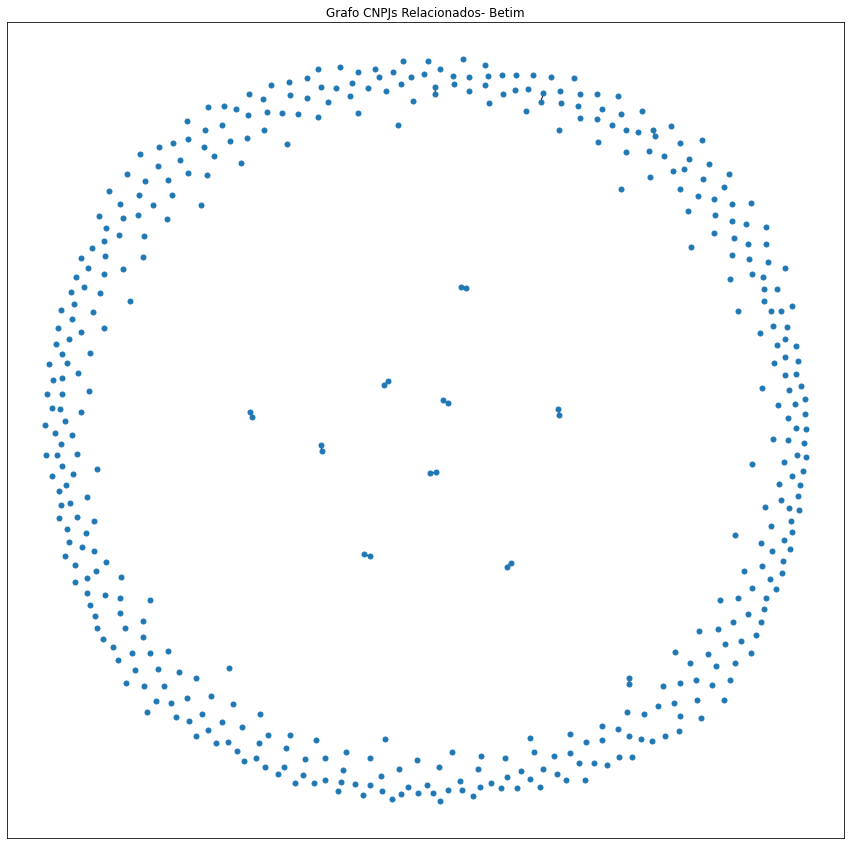

In [8]:
plota_grafo_municipio('Betim')

### Modularizando o codigo obtido:

In [9]:
def cnpjs_licitantes(municipio: str) -> pd.DataFrame:
    """Plota o grafo do municipio escolhido.
    Deve estar dentro do contexto dos DataFrames,
    possivel implementacao em classe.
    """
    licitacoes_do_municipio = informacoes_licitacoes.loc[informacoes_licitacoes['nom_entidade'] == municipio]
    licitacoes_do_municipio = licitacoes_do_municipio['seq_dim_licitacao']

    return cnpjs_por_licitacao[cnpjs_por_licitacao['seq_dim_licitacao'].isin(licitacoes_do_municipio)]

In [10]:
def gera_grafo(cnpjs: pd.DataFrame) -> nx.Graph:
    """Gera e retorna o grafo de CNPJs relacionados.
    """
    G = nx.Graph()
    # Passivel de melhorias, aninhamento
    for cnpj in cnpjs['num_documento']:
        G.add_node(cnpj)
        relacoes_do_cnpj = relacoes_entre_cnpjs.loc[relacoes_entre_cnpjs[0] == cnpj]
        for relacao in relacoes_do_cnpj.values:
            if relacao[1] in cnpjs.values:
                G.add_edge(relacao[0], relacao[1])
    return G

In [11]:
def plota_grafo(grafo: nx.Graph) -> plt.figure:
    """Plota o grafo.
    """    
    plt.figure(figsize=(15, 15))    
    pos = nx.spring_layout(grafo)
    nx.draw_networkx_nodes(grafo, pos, node_size=25)
    nx.draw_networkx_edges(grafo, pos)
    plt.show()

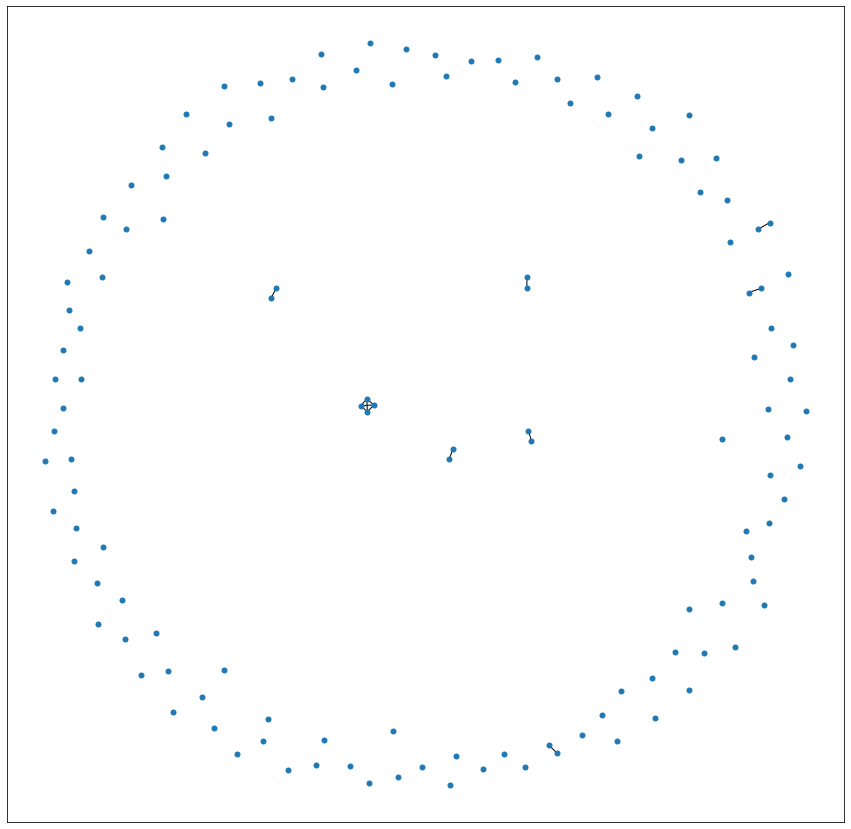

In [12]:
plota_grafo(gera_grafo(cnpjs_licitantes('Catas Altas da Noruega')))

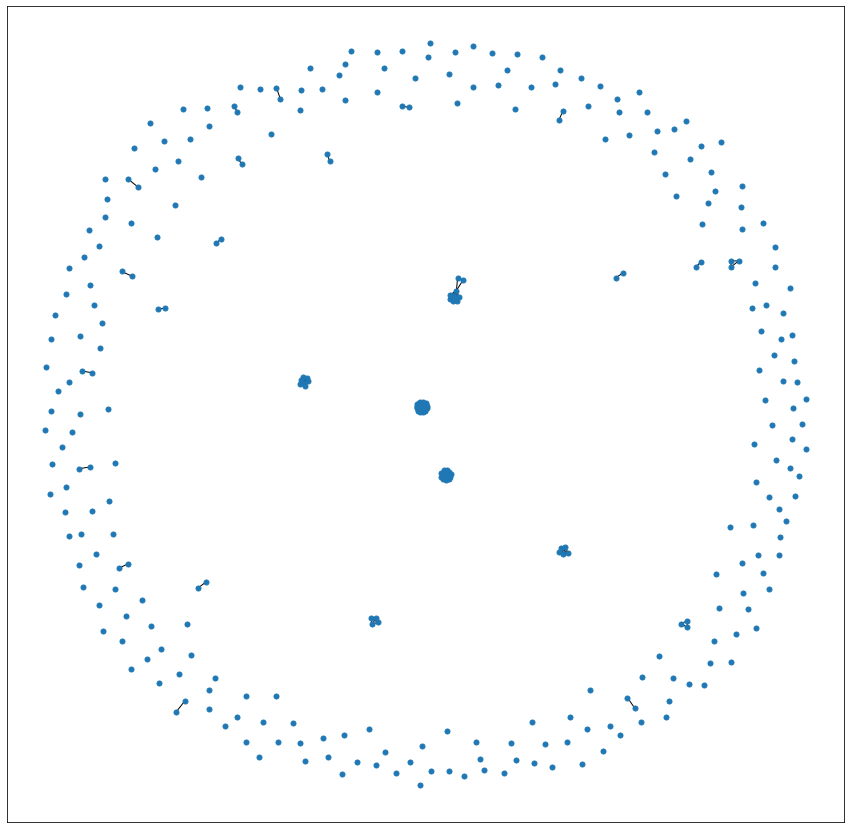

In [13]:
plota_grafo(gera_grafo(cnpjs_licitantes('Espera Feliz')))

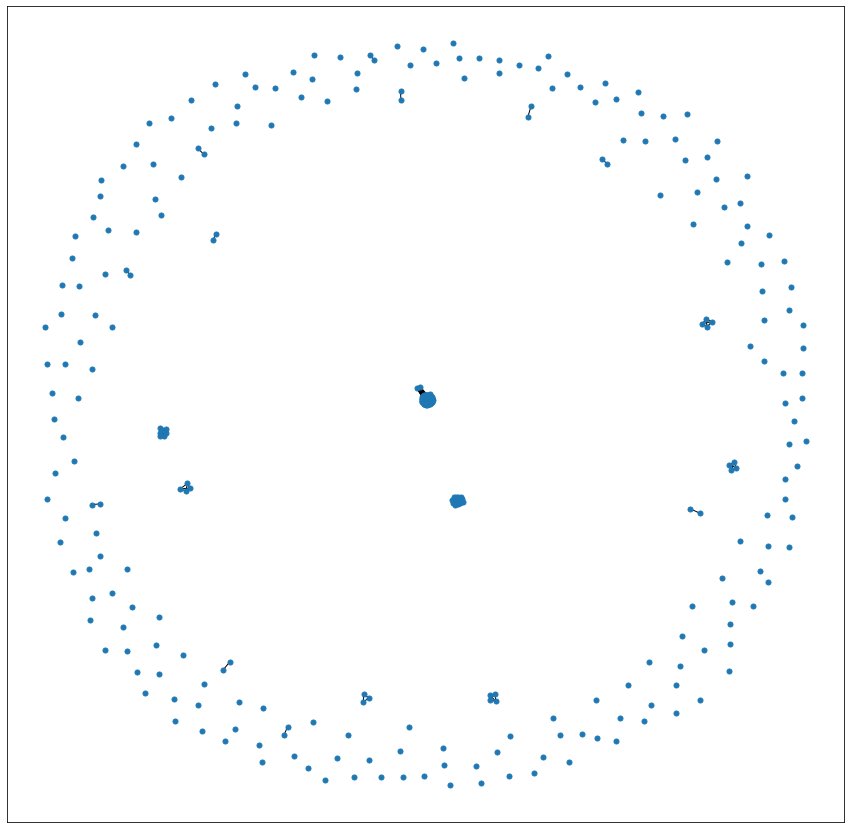

In [14]:
plota_grafo(gera_grafo(cnpjs_licitantes('Rio Pardo de Minas')))